In [1]:
from getpass import getpass

profile_name = 'default'
region_name = 'us-east-1'
aws_access_key_id = getpass('access id')
aws_secret_access_key = getpass('access key')

access id ········
access key ········


In [2]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates
import logging
import boto3
import pandas as pd
import pyarrow.parquet as pq
import io
import os
from botocore.exceptions import ClientError

In [3]:
#connect to s3
print('get_s3_client: profile_name=%s, region_name=%s' % (profile_name, region_name))

session = boto3.Session(profile_name=profile_name)
s3 = session.client('s3',
    region_name=region_name)

get_s3_client: profile_name=default, region_name=us-east-1


In [4]:
s3 = boto3.resource(
    service_name='s3',
    region_name= region_name,
    aws_access_key_id= aws_access_key_id,
    aws_secret_access_key = aws_secret_access_key
)
buffer = io.BytesIO()

In [5]:
#view buckets
for bucket in s3.buckets.all():
    print(bucket.name)

training-prediction-s3


In [6]:
source = s3.Bucket('training-prediction-s3').Object('raw/run_ww_2020_d.parquet')
source.download_fileobj(buffer)
df_2020 = pd.read_parquet(buffer)

In [7]:
df_2020.head()

,datetime,athlete,distance,duration,gender,age_group,country,major
0,2020-01-01,0,0.00,0.000000,F,18 - 34,United States,CHICAGO 2019
1,2020-01-01,1,5.72,31.633333,M,35 - 54,Germany,BERLIN 2016
2,2020-01-01,2,0.00,0.000000,M,35 - 54,United Kingdom,"LONDON 2018,LONDON 2019"
3,2020-01-01,3,0.00,0.000000,M,18 - 34,United Kingdom,LONDON 2017
4,2020-01-01,4,8.07,38.616667,M,35 - 54,United States,BOSTON 2017


In [8]:
df_2020['datetime2'] = df_2020['datetime'].astype('string')
df_2020['month'] = df_2020['datetime2'].str.slice(5, 7)
df_2020['day'] = df_2020['datetime2'].str.slice(8, )
df_2020['month'] = df_2020['month'].astype(int)
df_2020['day'] = df_2020['day'].astype(int)
df_2020.dtypes

datetime     datetime64[ns]
athlete               int64
distance            float64
duration            float64
gender               object
age_group            object
country              object
major                object
datetime2            string
month                 int64
day                   int64
dtype: object

In [9]:
import calendar
import numpy as np
calendar.setfirstweekday(6)

def get_week_of_month(year, month, day):
    x = np.array(calendar.monthcalendar(year, month))
    week_of_month = np.where(x==day)[0][0] + 1
    return(week_of_month)

In [10]:
df_2020['week_no_in_month'] = df_2020.apply(lambda x: get_week_of_month(2020, x['month'], x['day']), axis=1)

In [11]:
df_2020['day_run'] = df_2020.apply(lambda row: 1 if row['distance'] > 0 else 0, axis=1)

In [12]:
df_2020_agg_week = pd.DataFrame(df_2020.groupby(['athlete', 'month', 'week_no_in_month']).agg({"distance": sum, "duration": sum, "day_run": sum}))
df_2020_agg_week.head()

distance  duration  day_run
athlete month week_no_in_month                             
0       1     1                      0.0       0.0        0
              2                      0.0       0.0        0
              3                      0.0       0.0        0
              4                      0.0       0.0        0
              5                      0.0       0.0        0

In [13]:
df_2020_agg_week = df_2020_agg_week.reset_index()
df_2020_agg_week['pace'] = (df_2020_agg_week['duration'])/(df_2020_agg_week['distance'])

In [14]:
df_2020_agg_week['pace'] = df_2020_agg_week.pace.fillna(0)

In [15]:
df_2020_agg_week2 = pd.DataFrame(df_2020_agg_week.groupby(['athlete', 'month']).agg({"distance": 'mean', "pace": 'mean', "day_run": 'mean'}))
df_2020_agg_week2 = df_2020_agg_week2.reset_index()

In [16]:
df_athlete_ids = df_2020.groupby('athlete').agg({"age_group": "first","gender": "first", "country": "first"})
df_athlete_ids = df_athlete_ids.reset_index()

In [17]:
df_2020_athletes_months = df_2020_agg_week2.merge(df_athlete_ids, on='athlete', how='outer')
df_2020_athletes_months.head()

,athlete,month,distance,pace,day_run,age_group,gender,country
0,0,1,0.000000,0.000000,0.000000,18 - 34,F,United States
1,0,2,1.300000,1.049744,0.200000,18 - 34,F,United States
2,0,3,5.508000,4.255836,1.000000,18 - 34,F,United States
3,0,4,7.590000,4.435107,1.400000,18 - 34,F,United States
4,0,5,3.636667,2.815836,0.666667,18 - 34,F,United States


## this is first half now for second half

In [18]:
df_2020['distance_rounded'] = df_2020.distance.round()

In [19]:
df_2020['athlete_month'] = df_2020["athlete"].astype(str) + "_" + df_2020["month"].astype(str)

In [20]:
value_counts_in_month = df_2020.groupby(['athlete_month', 'distance_rounded']).size().reset_index(name='count')
df_2020_athletes_months['athlete_month2'] = df_2020_athletes_months["athlete"].astype(str) + "_" + df_2020_athletes_months["month"].astype(str)
value_counts_in_month[['athlete', 'month']] = value_counts_in_month.athlete_month.str.split("_", expand = True)

In [21]:
value_counts_in_month['athlete'] = value_counts_in_month['athlete'].astype(int)
value_counts_in_month['month'] = value_counts_in_month['month'].astype(int)
value_counts_in_month.dtypes

athlete_month        object
distance_rounded    float64
count                 int64
athlete               int64
month                 int64
dtype: object

In [22]:
def days_in_month(year, month):
    _, num_days = calendar.monthrange(year, month)
    return num_days


days_in_month(2023,6)

30

In [23]:
value_counts_in_month['days_in_month'] = value_counts_in_month.apply(lambda x: days_in_month(2020, x['month']), axis=1)
value_counts_in_month['weekly_frequency'] = value_counts_in_month['count'] / (value_counts_in_month['days_in_month'] / 7)

In [24]:
def month_name_from_number(month_number):
    if 1 <= month_number <= 12:
        return calendar.month_name[month_number]
    else:
        return None  # You can handle invalid month numbers as per your requirements



In [25]:
# Create a new 'month_name' column in the DataFrame
value_counts_in_month['current_month'] = value_counts_in_month['month'].apply(month_name_from_number)

value_counts_in_month.loc[value_counts_in_month['month'] > 1, 'previous_month'] = value_counts_in_month['month'] - 1
value_counts_in_month['previous_month'] = value_counts_in_month['previous_month'].astype('string')
value_counts_in_month['athlete_month2'] = value_counts_in_month['athlete'].astype('string') + '_'+ value_counts_in_month['previous_month'].str[:-2]
value_counts_in_month2 = value_counts_in_month[['athlete_month', 'athlete_month2', 'athlete','current_month', 'distance_rounded', 'weekly_frequency']]

df_2020_athletes_prev_months = df_2020_athletes_months[['athlete_month2', 'distance', 'pace', 'day_run']]

In [26]:
df_2020_athletes_identities = df_2020_athletes_months[['athlete', 'age_group','gender','country']]
value_counts_in_month2['athlete_month2'] = value_counts_in_month2['athlete_month2'].astype('object')

df_2020_athletes_identities['athlete'] = df_2020_athletes_identities['athlete'].astype('int')
df_2020_athletes_identities.dtypes

/tmp/ipykernel_6945/3560025548.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  value_counts_in_month2['athlete_month2'] = value_counts_in_month2['athlete_month2'].astype('object')
/tmp/ipykernel_6945/3560025548.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2020_athletes_identities['athlete'] = df_2020_athletes_identities['athlete'].astype('int')


athlete       int64
age_group    object
gender       object
country      object
dtype: object

In [27]:
merged_a = value_counts_in_month2.merge(df_2020_athletes_prev_months, on='athlete_month2', how='left')
merged_b = merged_a.merge(df_2020_athletes_identities.drop_duplicates(subset=['athlete']),on='athlete', how='left')

In [28]:
new_column_names = {
    'distance': 'prev_month_weekly_km',
    'pace': 'prev_month_weekly_pace',
    'day_run': 'prev_month_weekly_days_run',
    'age_group': 'age_bucket',
    'distance_rounded': 'run_distance_rounded',
}

merged_b = merged_b.rename(columns=new_column_names)
merged_b.head()

,athlete_month,athlete_month2,athlete,current_month,run_distance_rounded,weekly_frequency,prev_month_weekly_km,prev_month_weekly_pace,prev_month_weekly_days_run,age_bucket,gender,country
0,0_1,<NA>,0,January,0.0,7.000000,NaN,NaN,NaN,18 - 34,F,United States
1,0_10,0_9,0,October,0.0,6.096774,6.198,3.630120,1.2,18 - 34,F,United States
2,0_10,0_9,0,October,4.0,0.225806,6.198,3.630120,1.2,18 - 34,F,United States
3,0_10,0_9,0,October,6.0,0.677419,6.198,3.630120,1.2,18 - 34,F,United States
4,0_11,0_10,0,November,0.0,5.600000,4.444,2.336156,0.8,18 - 34,F,United States


In [57]:
input_data_2020 = merged_b[['athlete', 'prev_month_weekly_km', 'prev_month_weekly_pace', 'prev_month_weekly_days_run','age_bucket', 'gender', 'country', 'current_month', 'run_distance_rounded', 'weekly_frequency']]
input_data_2020_nozeros = input_data_2020[input_data_2020['run_distance_rounded'] > 0]

In [58]:
input_data_2020_nozeros.sample(10)

,athlete,prev_month_weekly_km,prev_month_weekly_pace,prev_month_weekly_days_run,age_bucket,gender,country,current_month,run_distance_rounded,weekly_frequency
2571189,4007,0.000000,0.000000,0.0,18 - 34,M,United Kingdom,August,11.0,0.225806
2881141,7236,25.350000,5.738924,1.4,18 - 34,M,United Kingdom,March,21.0,0.225806
2322672,35198,33.728333,5.471490,2.0,18 - 34,M,Germany,July,49.0,0.225806
470369,14955,26.080000,7.082155,3.4,35 - 54,F,United States,December,2.0,0.225806
1088596,21595,38.746000,5.065998,3.6,35 - 54,M,Switzerland,May,7.0,0.225806
1012783,20767,14.660000,3.355847,0.8,35 - 54,F,United States,October,43.0,0.225806
2045608,32280,NaN,NaN,NaN,18 - 34,M,United Kingdom,January,20.0,0.225806
1690267,28055,34.308000,5.788270,3.2,35 - 54,M,United Kingdom,May,13.0,0.225806
131884,11361,16.396667,7.243326,2.5,35 - 54,F,Indonesia,July,10.0,0.225806
1144961,22206,41.337600,5.421444,3.8,35 - 54,M,Canada,May,5.0,1.129032


In [59]:
try:
    os.mkdir('../../raw')
except:
    print('dir already exists')
input_data_2020_nozeros.to_csv('../../raw/input_runners_2020.csv', index=False)

dir already exists


## 2019 Data

In [33]:
source = s3.Bucket('training-prediction-s3').Object('raw/run_ww_2019_d.parquet')
source.download_fileobj(buffer)
df_2019 = pd.read_parquet(buffer)

In [34]:
df_2019['datetime2'] = df_2019['datetime'].astype('string')
df_2019['month'] = df_2019['datetime2'].str.slice(5, 7)
df_2019['day'] = df_2019['datetime2'].str.slice(8, )
df_2019['month'] = df_2019['month'].astype(int)
df_2019['day'] = df_2019['day'].astype(int)
df_2019.dtypes

datetime     datetime64[ns]
athlete               int64
distance            float64
duration            float64
gender               object
age_group            object
country              object
major                object
datetime2            string
month                 int64
day                   int64
dtype: object

In [35]:
df_2019['week_no_in_month'] = df_2019.apply(lambda x: get_week_of_month(2019, x['month'], x['day']), axis=1)

In [36]:
df_2019['day_run'] = df_2019.apply(lambda row: 1 if row['distance'] > 0 else 0, axis=1)

In [37]:
df_2019_agg_week = pd.DataFrame(df_2019.groupby(['athlete', 'month', 'week_no_in_month']).agg({"distance": sum, "duration": sum, "day_run": sum}))
df_2019_agg_week.head()

distance  duration  day_run
athlete month week_no_in_month                             
0       1     1                      0.0       0.0        0
              2                      0.0       0.0        0
              3                      0.0       0.0        0
              4                      0.0       0.0        0
              5                      0.0       0.0        0

In [38]:
df_2019_agg_week = df_2019_agg_week.reset_index()
df_2019_agg_week['pace'] = (df_2019_agg_week['duration'])/(df_2019_agg_week['distance'])

In [39]:
df_2019_agg_week['pace'] = df_2019_agg_week.pace.fillna(0)

In [40]:
df_2019_agg_week2 = pd.DataFrame(df_2019_agg_week.groupby(['athlete', 'month']).agg({"distance": 'mean', "pace": 'mean', "day_run": 'mean'}))
df_2019_agg_week2 = df_2019_agg_week2.reset_index()

In [41]:
df_athlete_ids = df_2019.groupby('athlete').agg({"age_group": "first","gender": "first", "country": "first"})
df_athlete_ids = df_athlete_ids.reset_index()

In [42]:
df_2019_athletes_months = df_2019_agg_week2.merge(df_athlete_ids, on='athlete', how='outer')
df_2019_athletes_months.head()

,athlete,month,distance,pace,day_run,age_group,gender,country
0,0,1,0.0,0.0,0.0,18 - 34,F,United States
1,0,2,0.0,0.0,0.0,18 - 34,F,United States
2,0,3,0.0,0.0,0.0,18 - 34,F,United States
3,0,4,0.0,0.0,0.0,18 - 34,F,United States
4,0,5,0.0,0.0,0.0,18 - 34,F,United States


## this is first half now for second half

In [43]:
df_2019['distance_rounded'] = df_2019.distance.round()

In [44]:
df_2019['athlete_month'] = df_2019["athlete"].astype(str) + "_" + df_2019["month"].astype(str)

In [45]:
value_counts_in_month = df_2019.groupby(['athlete_month', 'distance_rounded']).size().reset_index(name='count')
df_2019_athletes_months['athlete_month2'] = df_2019_athletes_months["athlete"].astype(str) + "_" + df_2019_athletes_months["month"].astype(str)
value_counts_in_month[['athlete', 'month']] = value_counts_in_month.athlete_month.str.split("_", expand = True)

In [46]:
value_counts_in_month['athlete'] = value_counts_in_month['athlete'].astype(int)
value_counts_in_month['month'] = value_counts_in_month['month'].astype(int)
value_counts_in_month.dtypes

athlete_month        object
distance_rounded    float64
count                 int64
athlete               int64
month                 int64
dtype: object

In [47]:
value_counts_in_month['days_in_month'] = value_counts_in_month.apply(lambda x: days_in_month(2019, x['month']), axis=1)
value_counts_in_month['weekly_frequency'] = value_counts_in_month['count'] / (value_counts_in_month['days_in_month'] / 7)

In [48]:
def month_name_from_number(month_number):
    if 1 <= month_number <= 12:
        return calendar.month_name[month_number]
    else:
        return None  # You can handle invalid month numbers as per your requirements



In [49]:
# Create a new 'month_name' column in the DataFrame
value_counts_in_month['current_month'] = value_counts_in_month['month'].apply(month_name_from_number)

value_counts_in_month.loc[value_counts_in_month['month'] > 1, 'previous_month'] = value_counts_in_month['month'] - 1
value_counts_in_month['previous_month'] = value_counts_in_month['previous_month'].astype('string')
value_counts_in_month['athlete_month2'] = value_counts_in_month['athlete'].astype('string') + '_'+ value_counts_in_month['previous_month'].str[:-2]
value_counts_in_month2 = value_counts_in_month[['athlete_month', 'athlete_month2', 'athlete','current_month', 'distance_rounded', 'weekly_frequency']]

df_2019_athletes_prev_months = df_2019_athletes_months[['athlete_month2', 'distance', 'pace', 'day_run']]

In [50]:
df_2019_athletes_identities = df_2019_athletes_months[['athlete', 'age_group','gender','country']]
value_counts_in_month2['athlete_month2'] = value_counts_in_month2['athlete_month2'].astype('object')

df_2019_athletes_identities['athlete'] = df_2019_athletes_identities['athlete'].astype('int')
df_2019_athletes_identities.dtypes

/tmp/ipykernel_6945/962339242.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  value_counts_in_month2['athlete_month2'] = value_counts_in_month2['athlete_month2'].astype('object')
/tmp/ipykernel_6945/962339242.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2019_athletes_identities['athlete'] = df_2019_athletes_identities['athlete'].astype('int')


athlete       int64
age_group    object
gender       object
country      object
dtype: object

In [51]:
merged_a = value_counts_in_month2.merge(df_2019_athletes_prev_months, on='athlete_month2', how='left')
merged_b = merged_a.merge(df_2019_athletes_identities.drop_duplicates(subset=['athlete']),on='athlete', how='left')

In [52]:
new_column_names = {
    'distance': 'prev_month_weekly_km',
    'pace': 'prev_month_weekly_pace',
    'day_run': 'prev_month_weekly_days_run',
    'age_group': 'age_bucket',
    'distance_rounded': 'run_distance_rounded',
}

merged_b = merged_b.rename(columns=new_column_names)
merged_b.head()

,athlete_month,athlete_month2,athlete,current_month,run_distance_rounded,weekly_frequency,prev_month_weekly_km,prev_month_weekly_pace,prev_month_weekly_days_run,age_bucket,gender,country
0,0_1,<NA>,0,January,0.0,7.000000,NaN,NaN,NaN,18 - 34,F,United States
1,0_10,0_9,0,October,0.0,5.645161,47.48,6.185043,3.4,18 - 34,F,United States
2,0_10,0_9,0,October,4.0,0.225806,47.48,6.185043,3.4,18 - 34,F,United States
3,0_10,0_9,0,October,6.0,0.225806,47.48,6.185043,3.4,18 - 34,F,United States
4,0_10,0_9,0,October,8.0,0.225806,47.48,6.185043,3.4,18 - 34,F,United States


In [60]:
input_data_2019 = merged_b[['athlete', 'prev_month_weekly_km', 'prev_month_weekly_pace', 'prev_month_weekly_days_run','age_bucket', 'gender', 'country', 'current_month', 'run_distance_rounded', 'weekly_frequency']]
input_data_2019_nozeros = input_data_2019[input_data_2019['run_distance_rounded'] > 0]

In [61]:
try:
    os.mkdir('../../raw')
except:
    print('dir already exists')
input_data_2019_nozeros.to_csv('../../raw/input_runners_2019.csv', index=False)

dir already exists


<Axes: ylabel='Frequency'>

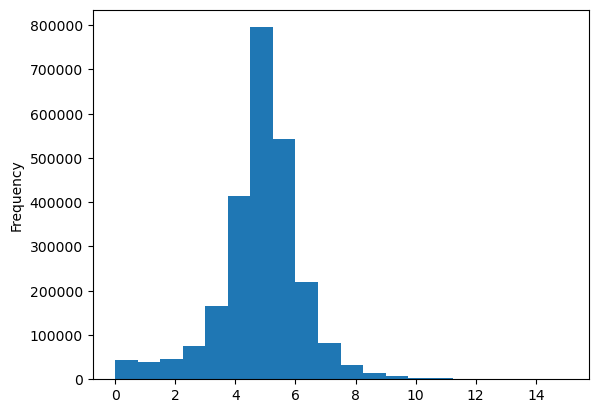

In [66]:
#check distrobutions
input_data_2019_nozeros['prev_month_weekly_pace'].plot.hist(bins=20,range = (0,15))

<Axes: ylabel='Frequency'>

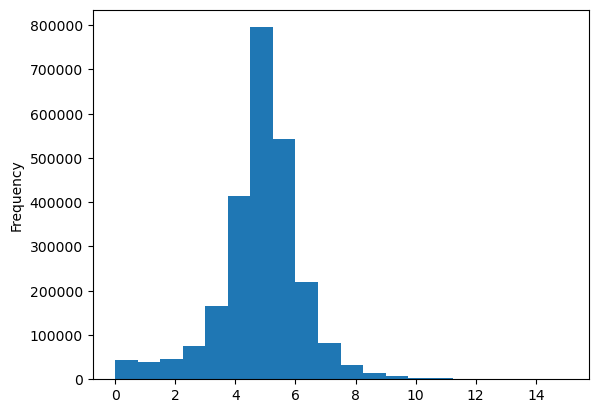

In [67]:
#check distrobutions
input_data_2020_nozeros['prev_month_weekly_pace'].plot.hist(bins=20,range = (0,15))